# Text Generation with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new text generation capabilities to train, evaluate, and deploy a BART summarization model.

- toc: false 
- badges: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, huggingface, blurr, text generation]
- image: images/articles/blurr-logo-small.png
- hide: false
- search_exclude: false
- show_tags: true

In [0]:
# only run this cell if you are in collab
# !pip install ohmeow-blurr
# !pip install nlp

In [0]:
import nlp
import pandas as pd
from fastai2.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

## Data Preparation

We're going to use to use the new [nlp](https://github.com/huggingface/nlp) library from huggingface to grab your raw data.  This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model.  The best part being everything comes down to you in JSON!  This makes it a breeze to get up and running quickly!

In [3]:
raw_data = nlp.load_dataset('cnn_dailymail')
raw_data.keys()

dict_keys(['test', 'train', 'validation'])

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [4]:
df = pd.DataFrame(raw_data['train'])
df.head()

,article,highlights
0,"(CNN) -- A blowout preventer that may hold important forensic evidence as to why it failed, triggering the world's largest accidental oil spill, has been brought to the surface of the Gulf and placed on a vessel, officials said Saturday night. The device ""was taken into custody by the U.S. Department of Justice as evidence in its ongoing investigation into the incident,"" BP said. The blowout preventer was lifted to the surface at 8:53 p.m. (9:53 p.m. ET). Adm. Thad Allen, the government's national incident commander, said the huge blowout preventer ""is considered evidentiary material."" The...",NEW: The failed blowout preventer is brought to the surface .\nA new blowout preventer has been placed on the capped well .\nBP will continue work on its Gulf relief well .
1,"(CNN) -- A controversial photography exhibit called ""In the Playroom"" depicts young children reenacting tragic and violent historical events, including the September 11 attacks and the abuse of inmates at Iraq's infamous Abu Ghraib prison. The artist, Jonathan Hobin, says his work is an attempt to reflect on modern events that affect children and prompt dialogue about ""issues in our world."" But the photos have also drawn criticism from those who say Hobin's use of artistic license involving children crosses an ethical boundary. ""Some of it is appropriate,"" said psychiatrist Alvin Poussaint...","Exhibit ""In the Playroom"" depicts young children re-enacting violent events .\nPhotographer Jonathan Hobin says it reflects on modern events that affect children .\nHe says the exhibit is supposed to prompt dialogue about ""issues in our world""\nThe photos have drawn criticism from those who say it crosses an ethical line ."
2,"(CNN)Wintry weather is a relative thing. The Northeast is on alert -- urging drivers to stay off roads -- as the fourth storm in three weeks drops snow that in Boston has exceeded 45 inches in February alone. It takes a fraction of that to get residents in the South into emergency mode. Sometimes, it doesn't even have to snow -- just the possibility of wintry weather is enough for a partial shutdown. ""Wintry precipitation possible"" early this week, the National Weather Service in Atlanta said. The Weather Service issued a winter storm watch for northern Georgia, warning of potential snow a...",Winter storm watch in effect for parts of the South .\nJust a little snow or ice can be enough to cause havoc .
3,"(CNN) -- U.S. Sgt. Bowe Bergdahl -- a former captive, a survivor and a hometown hero to many in Hailey, Idaho -- is being accused by some of his fellow soldiers of deserting his post. This charge of treason will be proven or dismissed in the coming weeks and months. But whether it is true or not, and whether he faces official military charges, he has already been sentenced to life to be haunted by his captivity -- and if the allegations are true, his choices. Survivors of the Hanoi Hilton, POWs during Vietnam such as Sen. John McCain and Medal of Honor winner Adm. James Stockdale, endured ...","Bowe Bergdahl a ""hometown hero"" in Hailey, Idaho, and a ""deserter"" to some soldiers .\nO'Shea: He learned Pashtun; building rapport with captors is critical to survival as a hostage .\nHe says Bergdahl probably wondered each day if this would be his last .\nTo break vow to fellow soldiers is terrible: If he indeed deserted, that will haunt him, too ."
4,"(CNN) -- Rafael Nadal continued his domination on clay as he crushed compatriot Guillermo Garcia-Lopez 6-1, 6-2 in the second round of the Barcelona Open. The Spaniard carved out 15 break points during the match, polishing off Garcia-Lopez in just over 80 minutes. It was Nadal's 30th straight victory at the event, where he has won six of the last seven titles at the Real Club de Tennis. Nadal has started the season in ominous form. After battling back from a serious knee injury, the world number two won his first title in ten months last week after finally beating riv

We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

In [5]:
pretrained_model_name = "bart-large-cnn"

hf_arch, hf_tokenizer, hf_config, hf_model = \
    BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, BartTokenizer, HF_MODELS.BartForConditionalGeneration)

hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('bart',
 transformers.tokenization_bart.BartTokenizer,
 transformers.configuration_bart.BartConfig,
 transformers.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice we're specifying `trg_max_length` to constrain our decoder inputs to 250 so that our input/predicted summaries will be padded to 250 rather than the default which is whatever you are using for your encoder inputs (e.g., the text you want summarized).

In [0]:
blocks = ( 
    HF_TextBlock(hf_arch, hf_tokenizer), 
    HF_TextBlock(hf_arch, hf_tokenizer, task=ForConditionalGenerationTask(), trg_max_length=250)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSubsetSplitter(0.05, 0.01))

In [0]:
dls = dblock.dataloaders(df, bs=4)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [8]:
b = dls.one_batch()
len(b), b[0][0].shape, b[1].shape

(2, torch.Size([4, 512]), torch.Size([4, 250]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.

In [9]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target
0,"Mauricio Pochettino might want to look up that old saying about houses built on sand. It might just ring a Christmas bell or two regarding a side who are reasonably capable of scoring but need some pointers on how to defend. That much was obvious here in a performance of numerous back-line errors that had to be redeemed by goals 85 minutes apart. Leading after four minutes through Harry Kane, Tottenham spent large swathes of what remained hanging on. Had Wilfried Bony made more of the space he was repeatedly afforded by Federico Fazio, this might have been a different result altogether. Tottenham Hotspur midfielder Christian Eriksen celebrates scoring an 89th-minute winner at the Liberty Stadium against Swansea City. Tottenham's Harry Kane (left), Eriksen (centre) and Jan Vertonghen (right) celebrate their 89th-minute winner on Sunday. Christian Eriksen (left) scores a late winner for Tottenham Hotspur as they took all three points away from the Liberty Stadium. Swansea City's (from left) Ashley Williams, Gylfi Sigurdsson, Jonjo Shelvey and Ki Sung-yueng look devastated after conceding late on. Harry Kane clinches his first in celebration after putting Tottenham Hotspur 1-0 ahead against Swansea City at the Liberty Stadium. Kane (centre) leaps above the Swansea defence to power a header into the back of the net in just the fourth minute of the game. The Tottenham forward clenches his fist in celebration and runs off into the corner after opening the scoring on Sunday. Kane (centre, obscured) is congratulated by team-mates after opening the scoring at the Liberty Stadium on Sunday. Instead, Bony scored only once and Tottenham rode a Swansea storm until Christian Eriksen picked their pocket at the other end. As Swansea manager Garry Monk put it: ‘It would have been stopped in the second half if it was a boxing match.’ Pochettino, meanwhile, was asked if there was a Spanish phrase for ‘smash and grab’, but he didn’t understand the question. Instead he focused on the ‘positives’, which in this case meant a first win in three league games and a tribute to the team’s spirit. Certainly, there was no shortage of application from Tottenham’s players when the going got tough and that has not always been the case in this strange season. SWANSEA CITY (4-2-3-1): Tremmel 6;","Harry Kane opens the scoring for Tottenham Hotspur with a header after only four minutes at the Liberty Stadium.\nWilfried Bony equalises for Swansea City (48mins) on his 50th Premier League appearance for the club.\nChristian Eriksen scores late winner for Spurs with a shot from just inside the penalty area.\nSpurs move up to seventh in the table and leapfrog the Swans, who now sit ninth in the Premier League."
1,"USA are on the verge of qualifying for the last-16 of the World Cup after a dramatic draw 2-2 with Portugal on Sunday. Jurgen Klinsmann's side had led the game until injury time before a last-gasp equaliser from Silvestre Varela delayed their passage into the second round. Either way it has been a superb tournament so far for the Americans, who also beat Ghana 2-1 in their opening game, now Sportsmail takes a look at the men who have taken them this far in Brazil. Soccer stars: USA are on the verge of qualification to the last-16 of the World Cup. Tim Howard – Everton. Born: New Jersey, March 6, 1979 (35) Clubs: North Jersey Imperials, Metrostars, Manchester United, Everton. Education: Raised in North Brunswick, one of the USA’s most successful exports in fact spent his formative years as a midfield player, balancing his talent for soccer with his obsession with basketball. Howard, affectionately known as Timmy by those who know him, was a teenage sensation on the court. His basketball coach Eddie Breheney recently told CBS: ‘Timmy’s athletic ability as a high school student was really off the charts. His agility, his hand-eye coordination, his stamina and just his love and passion for the game.’ By the age of 15, though, Howard was in goal f

## Training

We'll prepare our BART model for training by wrapping it in blurr's `HF_TextGenerationModelWrapper` model object.  This class will handle ensuring all our inputs get translated into the proper arguments needed by a huggingface conditional generation model.  We'll also use a custom model splitter that will allow us to apply discriminative learning rates over the various layers in our huggingface model.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with BART only thus far (if you try any other conditional generation transformer models they may or may not work ... if you do, lmk either way)

In [0]:
model = HF_TextGenerationModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(ignore_index=hf_tokenizer.pad_token_id),
                cbs=[HF_BaseModelCallback],
                splitter=partial(text_gen_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [12]:
b = dls.one_batch()
preds = learn.model(b[0])
len(b), len(b[0]), b[0][0].shape, len(b[1]), b[1].shape, len(preds), preds[0].shape

(2,
 4,
 torch.Size([4, 512]),
 4,
 torch.Size([4, 250]),
 2,
 torch.Size([4, 250, 50264]))

Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=6.309573450380412e-07)

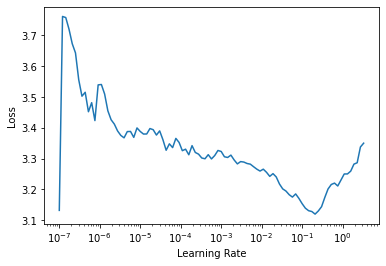

In [13]:
learn.lr_find(suggestions=True)

In [15]:
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,time
0,3.085961,2.904940,24:16


And now we can look at the "greedy decoded" predictions ...

In [16]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target,prediction
0,"(CNN) -- The 56th annual Grammy Awards were held in Los Angeles on Sunday night with performances from Lorde, Macklemore & Ryan Lewis, Jay Z, Beyonce and more. Take a look at some of the top winners below:. Record of the year. ""Get Lucky"" -- Daft Punk featuring Pharrell Williams and Nile Rodgers -- WINNER. ""Radioactive"" -- Imagine Dragons. ""Royals"" -- Lorde. ""Locked out of Heaven"" -- Bruno Mars. ""Blurred Lines"" -- Robin Thicke featuring T.I. and Pharrell. Album of the year. ""The Blessed Unrest"" -- Sara Bareilles. ""Random Access Memories"" -- Daft Punk -- WINNER. ""Good Kid, M.A.A.D City"" -- Kendrick Lamar. ""The Heist"" -- Macklemore & Ryan Lewis. ""Red"" -- Taylor Swift. 5 things we loved about the 2014 Grammys. Song of the year. ""Just Give Me a Reason"" -- P!nk featuring Nate Ruess. ""Locked Out of Heaven"" -- Bruno Mars. ""Roar"" -- Katy Perry. ""Royals"" -- Lorde -- WINNER. ""Same Love"" -- Macklemore & Ryan Lewis. Best new artist. James Blake. Kendrick Lamar. Macklemore & Ryan Lewis -- WINNER. Kacey Musgraves. Ed Sheeran. Best pop solo performance. Sara Bareilles -- ""Brave"" Lorde -- ""Royals"" -- WINNER. Bruno Mars -- ""When I Was Your Man"" Katy Perry -- ""Roar"" Justin Timberlake -- ""Mirrors"" Best pop duo/group performance. Daft Punk featuring Pharrell Williams and Nile Rodgers -- ""Get Lucky"" -- WINNER. P!nk featuring Nate Ruess -- ""Just Give Me a Reason"" Rihanna featuring Mikky Ekko -- ""Stay"" Robin Thicke featuring T.I. and Pharrell -- ""Blurred Lines"" Justin Timberlake and Jay Z -- ""Suit & Tie"" Best pop instrumental album. Herb Alpert -- ""Steppin' Out"" -- WINNER. Boney James -- ""The Beat"" Earl Klugh -- ""Handpicked"" Dave Koz, Gerald Albright, Mindi Abair and Richard Elliot -- ""Summer Horns"" Jeff Lorber Fusion -- ""Hacienda"" Best pop vocal album. Lana Del Rey -- ""Paradise"" Lorde -- ""Pure Heroine",Daft Punk were the big winners at the 56th annual Grammys.\nThe group won record of the year and album of the year.\nLorde won song of the year and best pop vocal.\nMacklemore & Ryan Lewis were named best new artist.,"The. Punk's named big winners. the Gramth annual Grammys. "" Punk album won album of the year and album of the year.</s>.orde won b"
1,"The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Uk

Even better though, blurr augments the fastai Learner with a `generate_text` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [0]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

In [18]:
outputs = learn.generate_text(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
The past 12 months have been the worst for aviation fatalities so far this decade. Total of number of people killed if airline crashes reached 1,050 even before Air Asia plane vanished. Two incidents involving Malaysia Airlines planes led to the deaths of 537 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies.

=== Prediction 2 ===
The past 12 months have been the worst for aviation fatalities so far this decade. Total of number of people killed if airline crashes reached 1,050 even before Air Asia plane vanished. Two incidents involving Malaysia Airlines planes led to the deaths of 537 people. But total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949.

=== Prediction 3 ===
The past 12 months have been the worst for aviation fatalities so far this decade. Total of number of people killed if airline crashes reached 1,05

What about inference?  Easy!

In [0]:
learn.export(fname='ft_cnndm_export.pkl')

In [20]:
inf_learn = load_learner(fname='ft_cnndm_export.pkl')
inf_learn.generate_text(test_article)

['The past 12 months have been the worst for aviation fatalities so far this decade. Total of number of people killed if airline crashes reached 1,050 even before Air Asia plane vanished. Two incidents involving Malaysia Airlines planes led to the deaths of 537 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies.']

## That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to text generation (e.g., sequence classification , token classification, and question/answering). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!